In [82]:
import jax.numpy as np
import jax
from transformers import FlaxCLIPModel, AutoProcessor

import sys
sys.path.append("../")

from models.dataset_utils import make_dataloader, create_input_iter
from models.text_utils import process_truncate_captions, tokenize_captions

In [83]:

batch_size = 8

files = ['../data/tfrecords_v3/observations_train_1.tfrecord','../data/tfrecords_v3/observations_train_2.tfrecord',]
ds = make_dataloader(files, batch_size=batch_size, seed=42)
batches = create_input_iter(ds)

In [84]:
model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [85]:
rng = jax.random.PRNGKey(42)
rng, rng_aug = jax.random.split(rng)

In [86]:
images, captions = next(iter(ds))
images = np.array(images)

captions = process_truncate_captions(captions, rng_aug, max_length_words=77)
inputs = processor(text=captions, images=images * 255.,  return_tensors="np", padding="max_length", truncation=True, max_length=77)
batch = inputs.data

In [87]:
outputs = model(**batch, params=model.params)

In [88]:
params_init = model.module.init(rng, input_ids=np.zeros((1, 77)), 
                   attention_mask=np.zeros((1, 77)),
                   pixel_values=np.zeros((1, 224, 224, 3)),
                   position_ids=np.zeros((1, 77)))

In [89]:
model.params.keys()

dict_keys(['logit_scale', 'text_model', 'text_projection', 'vision_model', 'visual_projection'])

In [90]:
model.params['vision_model'] = params_init['params']['vision_model']
model.params['visual_projection'] = params_init['params']['visual_projection']

In [91]:
# model.params['vision_model']

In [4]:
import optax

sched = optax.linear_schedule(0., 1e-4, 2000)

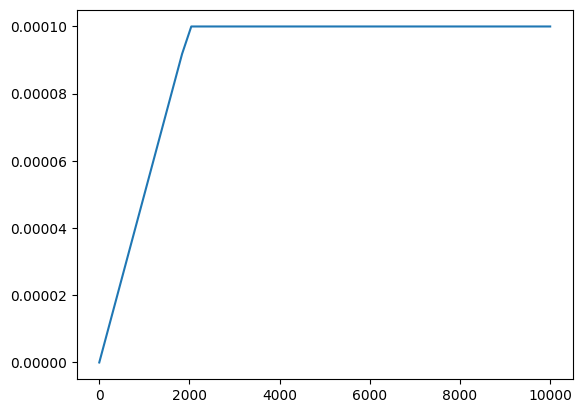

In [9]:
import jax.numpy as np
import matplotlib.pyplot as plt

steps_ary = np.linspace(0, 10_000)
plt.plot(steps_ary, sched(steps_ary))